In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
!pip install emoji

In [35]:
import torch
import torch.nn as nn
import json
import random
# from transformers import BertForSequenceClassification, AdamW, BertConfig
# from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
import re
import numpy as np
import emoji
# from transformers import *
from tqdm import tqdm
# from sklearn.model_selection import StratifiedKFold
# from transformers import BertTokenizer
# from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import accuracy_score,f1_score
from sklearn.utils.class_weight import compute_class_weight
# from transformers import BertTokenizer
# from transformers import BertForSequenceClassification, AdamW, BertConfig
# from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from sklearn.metrics import *
from sklearn.utils import *
import pandas as pd
import string

In [36]:
d1= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_en_l1.csv')
d3= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_en_l3.csv')

d1_test= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_en_l1.csv')
d3_test= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_en_l3.csv')


In [37]:
# # Verify GPU availability
# if not torch.cuda.is_available():
#     raise RuntimeError("GPU not available. Please enable GPU in your environment (e.g., Colab Runtime -> Change runtime type -> GPU).")
# print(f"Using GPU: {torch.cuda.get_device_name(0)}")

In [38]:
def normalize_text(text):
  # emoji_pattern = re.compile("["
  #                             u"\U0001F600-\U0001F64F"  # emoticons
  #                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
  #                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
  #                             u"\U0001F700-\U0001F77F"  # alchemical symbols
  #                             u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
  #                             u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
  #                             u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
  #                             u"\U0001FA00-\U0001FA6F"  # Chess Symbols
  #                             u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
  #                             u"\U00002702-\U000027B0"  # Dingbats
  #                             u"\U000024C2-\U0001F251"
  #                             "]+", flags=re.UNICODE)
  text = text.lower()
  text = re.sub('\[.*?\]', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', ' ', text)
  text = re.sub('<handle replaced>', '', text)
  text = emoji.demojize(text)
  text = text.replace("ðŸ¤§", " ")
  text = text.replace("&amp;", " ")
  text = text.replace("\n", " ")
  text = text.replace("ðŸ˜¡", " ")
  # text = emoji_pattern.sub(r'', text)
  return text

d1['text'] = d1['text'].apply(lambda x: normalize_text(x))
d1_test['text'] = d1_test['text'].apply(lambda x: normalize_text(x))

d3['text'] = d3['text'].apply(lambda x: normalize_text(x))
d3_test['text'] = d3_test['text'].apply(lambda x: normalize_text(x))

In [39]:
d1.head()
d3.head()

,text,key,en_a1,en_a2,en_a3,en_a4,en_a5,en_a6
0,this is our history for shia and sunni ...,question_3,NaN,NaN,NaN,NaN,NaN,0.0
1,if this is grilling then wht wud u call t...,question_3,NaN,NaN,NaN,1.0,NaN,NaN
2,look at madam locals attacked no religion...,question_3,NaN,NaN,NaN,NaN,0.0,NaN
3,our beloved yogi ji has given money home and...,question_3,NaN,NaN,NaN,NaN,1.0,NaN
4,i gonna kill that bitch bitvj imma kill you...,question_3,NaN,NaN,NaN,NaN,NaN,1.0


In [40]:
X1 = list(d1['text'])
X1_test = list(d1_test['text'])
X3 = list(d3['text'])
X3_test = list(d3_test['text'])

col_lst = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
for col in col_lst:
    d1[col] = pd.to_numeric(d1[col], errors='coerce')
    d1_test[col] = pd.to_numeric(d1_test[col], errors='coerce')

    d3[col] = pd.to_numeric(d3[col], errors='coerce')
    d3_test[col] = pd.to_numeric(d3_test[col], errors='coerce')


d1['label_1'] = d1[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values
d1_test['label_1'] = d1_test[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

d3['label_3'] = d3[col_lst].max(axis=1, skipna=True).astype(int)
d3_test['label_3'] = d3_test[col_lst].max(axis=1, skipna=True).astype(int)


d1 = d1.drop(col_lst, axis=1)
d1_test = d1_test.drop(col_lst, axis=1)
d3 = d3.drop(col_lst, axis=1)
d3_test = d3_test.drop(col_lst, axis=1)

d1['label_1'] = d1['label_1'].astype(int)
d1_test['label_1'] = d1_test['label_1'].astype(int)
d3['label_3'] = d3['label_3'].astype(int)
d3_test['label_3'] = d3_test['label_3'].astype(int)


d1 = d1[['label_1', 'text']]
d1_test = d1_test[['label_1', 'text']]
d1_test

d3 = d3[['label_3', 'text']]
d3_test = d3_test[['label_3', 'text']]
d3_test

,label_3,text
0,1,who s this tweet about bitch it s about you ...
1,0,alkalamba should’ve used her slippers to slap...
2,1,coronavillains covididiot is a do...
3,1,acts like the female governors of stat...
4,1,let us celebrate “secular” as a beautiful w...
...,...,...
1102,1,you should be tired of not having any kind of ...
1103,0,“the limits of tyrants are prescribed by the e...
1104,1,:Cancer::crab: like wtf my symbol is and i’m...
1105,1,:United_States: marry a millionaire guy divo...


In [41]:
dn = pd.concat([d1, d3.drop(columns=['text'])], axis=1)
dn_test = pd.concat([d1_test, d3_test.drop(columns=['text'])], axis=1)

dn = dn[['text', 'label_1', 'label_3']]
dn_test = dn_test[['text', 'label_1', 'label_3']]
dn_test

,text,label_1,label_3
0,who s this tweet about bitch it s about you ...,1,1
1,alkalamba should’ve used her slippers to slap...,0,0
2,coronavillains covididiot is a do...,1,1
3,acts like the female governors of stat...,1,1
4,let us celebrate “secular” as a beautiful w...,1,1
...,...,...,...
1102,you should be tired of not having any kind of ...,1,1
1103,“the limits of tyrants are prescribed by the e...,0,0
1104,:Cancer::crab: like wtf my symbol is and i’m...,1,1
1105,:United_States: marry a millionaire guy divo...,1,1


In [42]:
# Create new label column based on logic
def assign_label(row):
    label_1 = row['label_1']
    label_3 = row['label_3']

    # Handle NaN cases (rows with only label_1 or label_3)
    if pd.isna(label_1) and pd.isna(label_3):
        return np.nan  # Both missing
    elif pd.isna(label_1):
        # Only label_3 exists (from d3, d3_test)
        return 1 if label_3 == 1 else 0  # Treat as binary
    elif pd.isna(label_3):
        # Only label_1 exists (from d1, d1_test)
        return 2 if label_1 == 1 else 0  # Treat as binary
    else:
        # Both labels exist (unlikely unless datasets overlap)
        if label_1 == 0 and label_3 == 0:
            return 0
        elif label_1 == 0 and label_3 == 1:
            return 1
        elif label_1 == 1 and label_3 == 0:
            return 2
        else:  # label_1 == 1 and label_3 == 1
            return 3

# dn_new=dn.copy()
dn['label'] = dn.apply(assign_label, axis=1)

# dn_test_new=dn_test.copy()
dn_test['label'] = dn_test.apply(assign_label, axis=1)

dn

,text,label_1,label_3,label
0,this is our history for shia and sunni ...,0,0,0
1,if this is grilling then wht wud u call t...,1,1,3
2,look at madam locals attacked no religion...,0,0,0
3,our beloved yogi ji has given money home and...,1,1,3
4,i gonna kill that bitch bitvj imma kill you...,1,1,3
...,...,...,...,...
6526,“mama let’s research” bitch suck my dick :loud...,0,0,0
6527,:face_with_tears_of_joy::face_with_tears_of_jo...,0,0,0
6528,:face_with_tears_of_joy::face_with_tears_of_jo...,0,0,0
6529,:smiling_face_with_sunglasses: boys only luxur...,1,1,3


In [43]:
dn = dn[['label', 'text']].copy()
dn_test = dn_test[['label', 'text']].copy()
dn

,label,text
0,0,this is our history for shia and sunni ...
1,3,if this is grilling then wht wud u call t...
2,0,look at madam locals attacked no religion...
3,3,our beloved yogi ji has given money home and...
4,3,i gonna kill that bitch bitvj imma kill you...
...,...,...
6526,0,“mama let’s research” bitch suck my dick :loud...
6527,0,:face_with_tears_of_joy::face_with_tears_of_jo...
6528,0,:face_with_tears_of_joy::face_with_tears_of_jo...
6529,3,:smiling_face_with_sunglasses: boys only luxur...


In [44]:
from numpy import asarray
from numpy import zeros
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences


max_len = 100
max_features = 1000000000
embed_size = 300
tokenizer1 = Tokenizer(num_words=max_features, char_level=False)


In [45]:
tokenizer1.fit_on_texts(list(X1))
X1 = tokenizer1.texts_to_sequences(X1)
X1 = pad_sequences(X1, padding='post', maxlen=max_len)


In [46]:
y_data1 = dn["label"]
y1 = y_data1.values
print(y1)
print(len(y1))

[0 3 0 ... 0 3 0]
6531


In [47]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder1 = LabelEncoder()
y1 = label_encoder1.fit_transform(y1)

y1 = to_categorical(y1, num_classes=4)

In [48]:


embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/NLP_Project/NLP/glove.42B.300d.txt', encoding="utf8") ## using pre-trained or self-trained embeddings ##

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

vocab_size1 = len(tokenizer1.word_index) + 1  ## total distinct words is the Vocabulary ##
word_index = tokenizer1.word_index
num_words = min(max_features,len(word_index)+1)

embedding_matrix = zeros((num_words, embed_size)) ## has to be similar to glove dimension ##
for word, index in tokenizer1.word_index.items():
    if index >= max_features:
        continue
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        embedding_matrix[index] = embeddings_dictionary["unk"]

In [49]:
print(len(word_index)+1)

14943


In [50]:
embedding_matrix.shape

(14943, 300)

In [115]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout, Activation, Concatenate
)
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns


X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

num_classes = 4
epochs = 10
batch_size = 32


model1 = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=embed_size,
              weights=[embedding_matrix],
              trainable=True),
    Bidirectional(LSTM(512, return_sequences=False)),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    # Bidirectional(GRU(512, return_sequences=False)),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])




model1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

history1 = model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=epochs, batch_size=batch_size, verbose=1)



Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.4635 - loss: 1.2682 - precision: 0.4003 - recall: 0.0639 - val_accuracy: 0.6289 - val_loss: 0.9876 - val_precision: 0.6332 - val_recall: 0.6182
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6092 - loss: 0.9933 - precision: 0.6199 - recall: 0.5783 - val_accuracy: 0.6289 - val_loss: 0.9481 - val_precision: 0.6571 - val_recall: 0.5631
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6072 - loss: 0.9556 - precision: 0.6753 - recall: 0.5063 - val_accuracy: 0.6305 - val_loss: 0.9190 - val_precision: 0.6991 - val_recall: 0.4996
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6200 - loss: 0.9241 - precision: 0.7141 - recall: 0.4865 - val_accuracy: 0.6335 - val_loss: 0.9040 - val_precision: 0.7201 - val_recall: 0.4705
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6190 - loss: 0.9127 - precision: 0.7269 - recall: 0.4680 - val_accuracy: 0.6412 - va

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
                   precision    recall  f1-score   support

          Neutral       0.71      0.80      0.75       822
     Gender Abuse       0.46      0.16      0.24       234
Explicit Language       0.00      0.00      0.00        23
             Both       0.42      0.56      0.48       228

         accuracy                           0.63      1307
        macro avg       0.40      0.38      0.37      1307
     weighted avg       0.60      0.63      0.60      1307



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


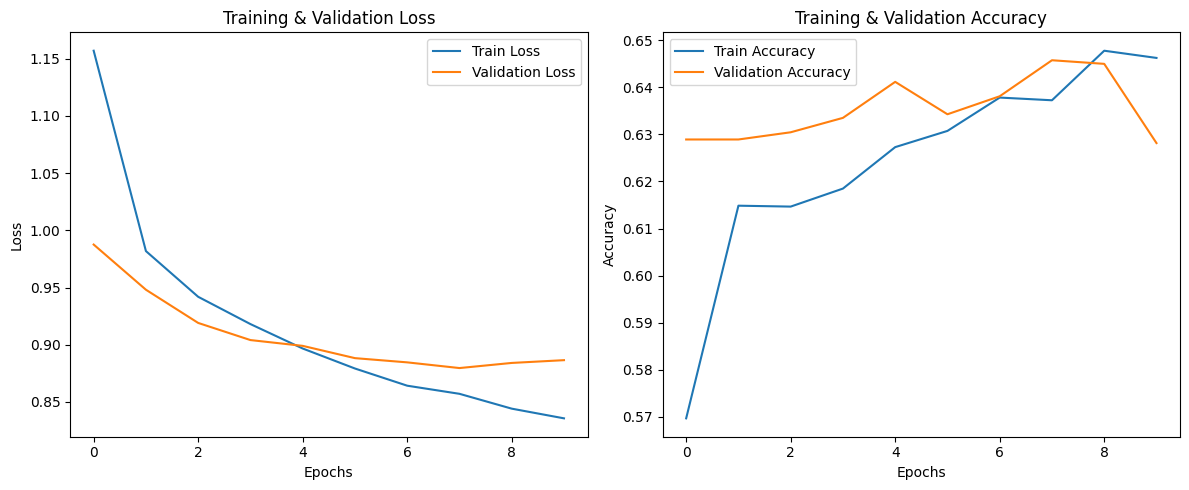

In [116]:
# Evaluate model
y_pred1 = np.argmax(model1.predict(X_val1), axis=1)
y_val_labels1 = np.argmax(y_val1, axis=1)
print(classification_report(y_val_labels1, y_pred1, target_names=["Neutral", "Gender Abuse", "Explicit Language", "Both"]))

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [117]:

# Compute F1 score, precision, and recall
accuracy = accuracy_score(y_val_labels1, y_pred1)
f1 = f1_score(y_val_labels1, y_pred1, average='macro')
precision = precision_score(y_val_labels1, y_pred1, average='macro')
recall = recall_score(y_val_labels1, y_pred1, average='macro')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.6281560826319816
F1 Score: 0.366647214731434
Precision: 0.39817021880759507
Recall: 0.37860181874300197


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


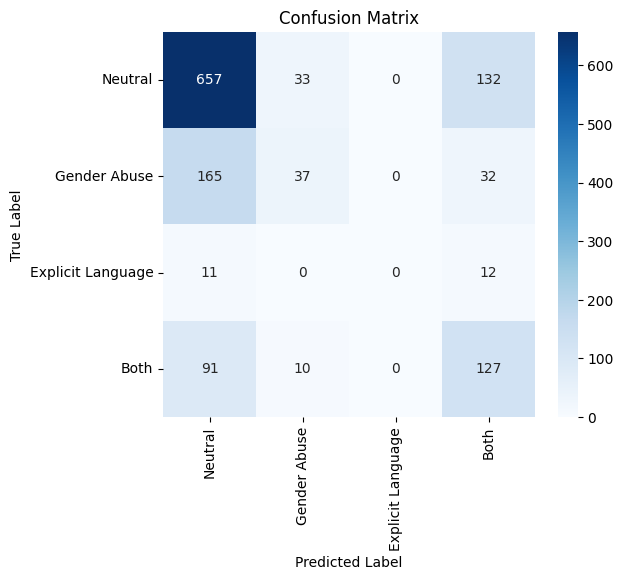

In [118]:
# Compute confusion matrix
cm = confusion_matrix(y_val_labels1, y_pred1)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Neutral", "Gender Abuse", "Explicit Language", "Both"], yticklabels=["Neutral", "Gender Abuse", "Explicit Language", "Both"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Testing


In [119]:

sequence1 = tokenizer1.texts_to_sequences(dn_test.text)
sequence1 = pad_sequences(sequence1, padding='post', maxlen=max_len)

predictions1 = model1.predict(sequence1)
classes1 = np.argmax(predictions1, axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [120]:
predictions1

print(len(predictions1))

1107


In [121]:
predictions1 = np.argmax(predictions1, axis=1)
print(predictions1)

[3 3 3 ... 3 3 0]


In [122]:
true_1 = dn_test["label"]
y_test_1 = true_1.values

print(y_test_1)
print(len(y_test_1))

[3 0 3 ... 3 3 3]
1107


In [123]:
ids = np.arange(1, len(y_test_1)+1)
result_df_1 = pd.DataFrame({'id': ids, 'prediction': predictions1, 'true': y_test_1})

In [124]:
def compute_metrics(result_df, color):
    # Compute metrics
    accuracy = accuracy_score(result_df['true'], result_df['prediction'])
    f1 = f1_score(result_df['true'], result_df['prediction'], average='macro')  # Use 'macro', 'micro', or 'weighted' as needed
    recall = recall_score(result_df['true'], result_df['prediction'], average='macro')
    precision = precision_score(result_df['true'], result_df['prediction'], average='macro')
    conf_matrix = confusion_matrix(result_df['true'], result_df['prediction'])

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    # print("Confusion Matrix:")
    # print(conf_matrix)

    conf_matrix = confusion_matrix(result_df['true'], result_df['prediction'])

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=color, xticklabels=set(result_df['true']), yticklabels=set(result_df['true']))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


Accuracy: 0.5059
F1 Score: 0.3268
Recall: 0.3543
Precision: 0.3968


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


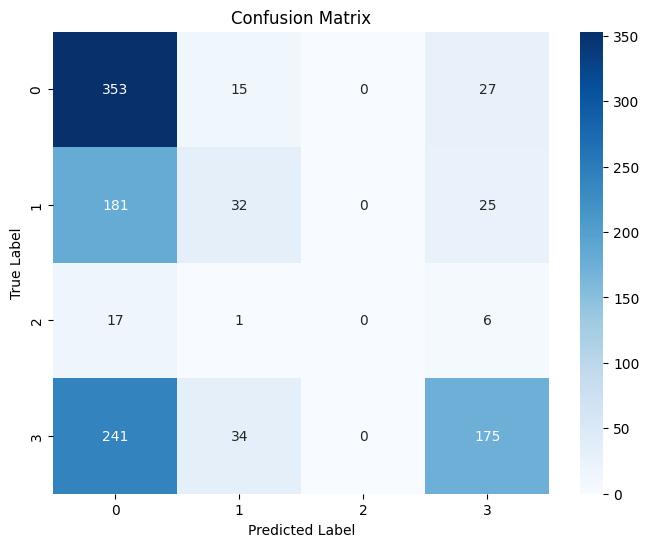

In [125]:
compute_metrics(result_df_1, "Blues")